程式碼來源:https://www.kaggle.com/pmmilewski/pca-decomposition-and-keras-neural-network/notebook

In [101]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D,Flatten,Conv2D,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist=input_data.read_data_sets("MNIST_data/",one_hot=True)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
test = mnist.test.images
train = mnist.train.images

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Which is 3 (3 in [2] position of the vector).


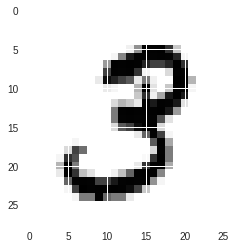

In [0]:
print(mnist.train.labels[1])
print('Which is 3 (3 in [2] position of the vector).')
plt.imshow(train[1].reshape((28,28)))

In [0]:
scaler = StandardScaler()
scaler.fit(train)
X_sc_train = scaler.transform(train)
X_sc_test = scaler.transform(test)

Text(0, 0.5, 'Cumulative explained variance')

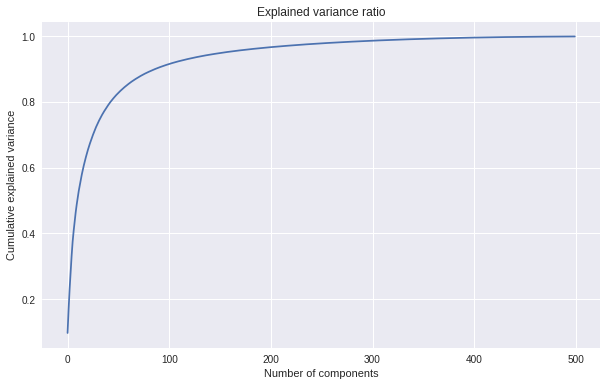

In [0]:
pca = PCA(n_components=500)
pca.fit(train)
plt.figure(figsize=(10,6))
plt.title("Explained variance ratio")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [0]:
NCOMPONENTS = 400

pca = PCA(n_components=NCOMPONENTS)
#x_pca_train是降維後的train dataset(餵給model的)
X_pca_train = pca.fit_transform(X_sc_train)
#x_pca_test是降維後的test dataset(餵給model的)
X_pca_test = pca.transform(X_sc_test)
pca_std = np.std(X_pca_train)

print(X_sc_train.shape)
print(X_pca_train.shape)

(55000, 784)
(55000, 400)


In [0]:
X_pca_test.shape

(10000, 400)

In [0]:
inv_pca = pca.inverse_transform(X_pca_train)
inv_sc = scaler.inverse_transform(inv_pca)

In [0]:
inv_pca_test = pca.inverse_transform(X_pca_test)
inv_sc_test = scaler.inverse_transform(inv_pca_test)

In [0]:
inv_sc_test.shape

(10000, 784)

In [0]:
def side_by_side(indexes):
    org = train[indexes].reshape(28,28)
    rec = inv_sc[indexes].reshape(28,28)
    pair = np.concatenate((org, rec), axis=1)
    plt.figure(figsize=(4,2))
    plt.imshow(pair)

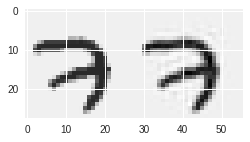

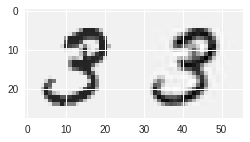

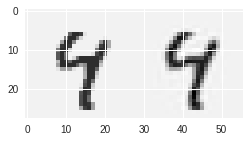

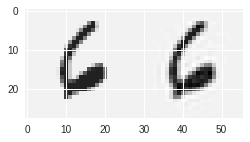

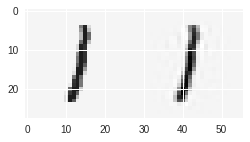

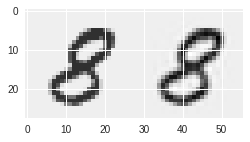

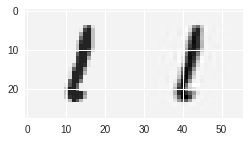

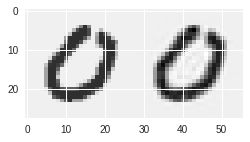

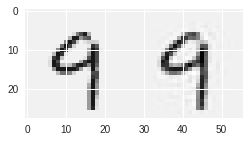

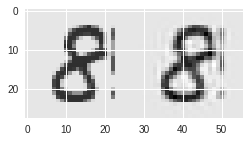

In [0]:
for index in range(0,10):
    side_by_side(index)

## PCA預處理降維搭配MLP
Dropout=0.8


In [0]:
tStart = time.time()
model = Sequential()
layers = 1
units = 128
#用2層fully connect全連接層(不含Input和Output層)做NN
model.add(Dense(units, input_dim=NCOMPONENTS, activation='relu'))
#加bias
model.add(GaussianNoise(pca_std))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    #加bias
    model.add(GaussianNoise(pca_std))
    model.add(Dropout(0.8))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
train_history=model.fit(X_pca_train,mnist.train.labels, epochs=100, batch_size=100, verbose=2,validation_split=0.2)
tEnd = time.time()
duration=tEnd-tStart
print("Train Finished takes:",duration,"sec")

Train on 44000 samples, validate on 11000 samples
Epoch 1/100
 - 3s - loss: 2.9299 - categorical_accuracy: 0.4368 - val_loss: 0.3528 - val_categorical_accuracy: 0.9018
Epoch 2/100
 - 2s - loss: 0.7520 - categorical_accuracy: 0.7759 - val_loss: 0.2648 - val_categorical_accuracy: 0.9247
Epoch 3/100
 - 2s - loss: 0.5457 - categorical_accuracy: 0.8386 - val_loss: 0.2290 - val_categorical_accuracy: 0.9338
Epoch 4/100
 - 2s - loss: 0.4624 - categorical_accuracy: 0.8659 - val_loss: 0.2140 - val_categorical_accuracy: 0.9394
Epoch 5/100
 - 2s - loss: 0.4135 - categorical_accuracy: 0.8801 - val_loss: 0.1934 - val_categorical_accuracy: 0.9452
Epoch 6/100
 - 2s - loss: 0.3777 - categorical_accuracy: 0.8904 - val_loss: 0.1938 - val_categorical_accuracy: 0.9478
Epoch 7/100
 - 2s - loss: 0.3493 - categorical_accuracy: 0.8977 - val_loss: 0.1737 - val_categorical_accuracy: 0.9530
Epoch 8/100
 - 2s - loss: 0.3286 - categorical_accuracy: 0.9034 - val_loss: 0.1668 - val_categorical_accuracy: 0.9566
Epoch 

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               51328     
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 69,130
Trainable params: 69,130
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
def show_train_history(train_history,train,validation):
  plt.plot(train_history.history[train])
  plt.plot(train_history.history[validation])
  plt.title("Train History")
  plt.ylabel(train)
  plt.xlabel("Epoch")
  plt.legend(["train",'validation'],loc='upper left')

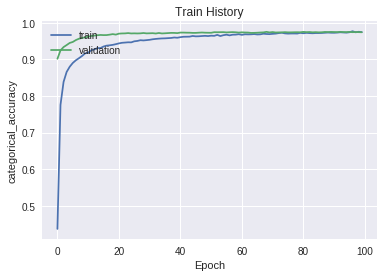

In [0]:
show_train_history(train_history,"categorical_accuracy","val_categorical_accuracy")

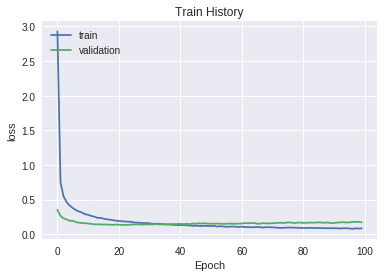

In [0]:
show_train_history(train_history,"loss","val_loss")

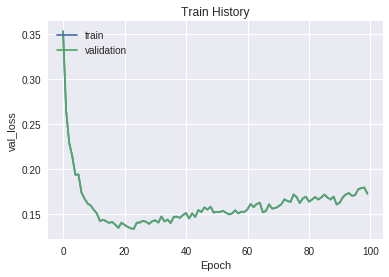

In [0]:
show_train_history(train_history,"val_loss","val_loss")

In [0]:
scores=model.evaluate(X_pca_test,mnist.test.labels)
print()
print("Accuuracy=",scores[1])

10000/10000 [==============================] - 0s 24us/step

Accuuracy= 0.9755


## PCA預處理降維搭配MLP
Dropout=0.5

In [0]:
tStart6 = time.time()
model = Sequential()
layers = 1
units = 128
#用2層fully connect全連接層(不含Input和Output層)做NN
model.add(Dense(units, input_dim=NCOMPONENTS, activation='relu'))
#加bias
model.add(GaussianNoise(pca_std))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    #加bias
    model.add(GaussianNoise(pca_std))
    model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
train_history6=model.fit(X_pca_train,mnist.train.labels, epochs=100, batch_size=100, verbose=2,validation_split=0.2)
tEnd6 = time.time()
duration6=tEnd6-tStart6
print("Train Finished takes:",duration6,"sec")

Train on 44000 samples, validate on 11000 samples
Epoch 1/100
 - 3s - loss: 1.5110 - categorical_accuracy: 0.6354 - val_loss: 0.2669 - val_categorical_accuracy: 0.9249
Epoch 2/100
 - 2s - loss: 0.4569 - categorical_accuracy: 0.8720 - val_loss: 0.2164 - val_categorical_accuracy: 0.9385
Epoch 3/100
 - 2s - loss: 0.3285 - categorical_accuracy: 0.9051 - val_loss: 0.1796 - val_categorical_accuracy: 0.9489
Epoch 4/100
 - 2s - loss: 0.2659 - categorical_accuracy: 0.9221 - val_loss: 0.1607 - val_categorical_accuracy: 0.9531
Epoch 5/100
 - 2s - loss: 0.2276 - categorical_accuracy: 0.9313 - val_loss: 0.1469 - val_categorical_accuracy: 0.9592
Epoch 6/100
 - 2s - loss: 0.2021 - categorical_accuracy: 0.9400 - val_loss: 0.1374 - val_categorical_accuracy: 0.9617
Epoch 7/100
 - 2s - loss: 0.1791 - categorical_accuracy: 0.9471 - val_loss: 0.1273 - val_categorical_accuracy: 0.9642
Epoch 8/100
 - 2s - loss: 0.1635 - categorical_accuracy: 0.9508 - val_loss: 0.1262 - val_categorical_accuracy: 0.9672
Epoch 

In [0]:
scores6=model.evaluate(X_pca_test,mnist.test.labels)
print()
print("Accuuracy=",scores6[1])

10000/10000 [==============================] - 0s 25us/step

Accuuracy= 0.9766


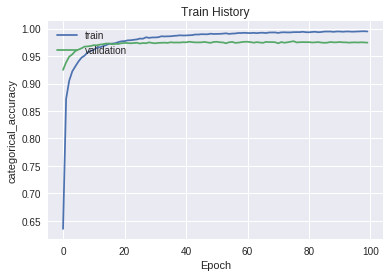

In [0]:
show_train_history(train_history6,"categorical_accuracy","val_categorical_accuracy")

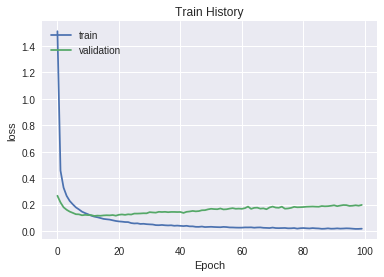

In [0]:
show_train_history(train_history6,"loss","val_loss")

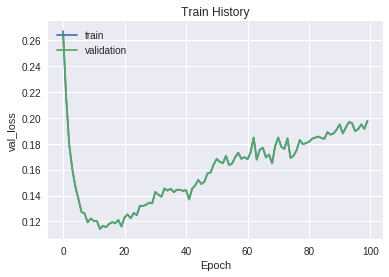

In [0]:
show_train_history(train_history6,"val_loss","val_loss")

## PCA預處理降維搭配MLP
Dropout=0.3

In [0]:
tStart7 = time.time()
model = Sequential()
layers = 1
units = 128
#用2層fully connect全連接層(不含Input和Output層)做NN
model.add(Dense(units, input_dim=NCOMPONENTS, activation='relu'))
#加bias
model.add(GaussianNoise(pca_std))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    #加bias
    model.add(GaussianNoise(pca_std))
    model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
train_history7=model.fit(X_pca_train,mnist.train.labels, epochs=100, batch_size=100, verbose=2,validation_split=0.2)
tEnd7 = time.time()
duration7=tEnd7-tStart7
print("Train Finished takes:",duration7,"sec")

Train on 44000 samples, validate on 11000 samples
Epoch 1/100
 - 3s - loss: 1.1571 - categorical_accuracy: 0.6975 - val_loss: 0.2506 - val_categorical_accuracy: 0.9297
Epoch 2/100
 - 2s - loss: 0.3907 - categorical_accuracy: 0.8891 - val_loss: 0.1864 - val_categorical_accuracy: 0.9453
Epoch 3/100
 - 2s - loss: 0.2777 - categorical_accuracy: 0.9186 - val_loss: 0.1634 - val_categorical_accuracy: 0.9542
Epoch 4/100
 - 2s - loss: 0.2233 - categorical_accuracy: 0.9339 - val_loss: 0.1462 - val_categorical_accuracy: 0.9592
Epoch 5/100
 - 2s - loss: 0.1835 - categorical_accuracy: 0.9444 - val_loss: 0.1375 - val_categorical_accuracy: 0.9605
Epoch 6/100
 - 2s - loss: 0.1633 - categorical_accuracy: 0.9499 - val_loss: 0.1257 - val_categorical_accuracy: 0.9639
Epoch 7/100
 - 2s - loss: 0.1418 - categorical_accuracy: 0.9566 - val_loss: 0.1221 - val_categorical_accuracy: 0.9669
Epoch 8/100
 - 2s - loss: 0.1273 - categorical_accuracy: 0.9605 - val_loss: 0.1147 - val_categorical_accuracy: 0.9695
Epoch 

In [0]:
scores7=model.evaluate(X_pca_test,mnist.test.labels)
print()
print("Accuuracy=",scores7[1])

10000/10000 [==============================] - 0s 26us/step

Accuuracy= 0.9746


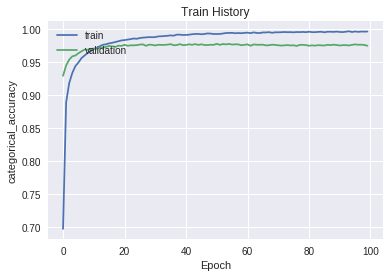

In [0]:
show_train_history(train_history7,"categorical_accuracy","val_categorical_accuracy")

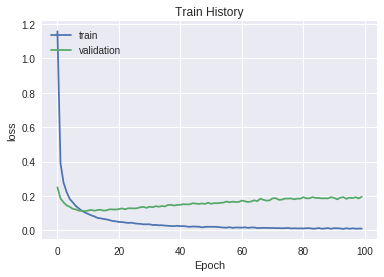

In [0]:
show_train_history(train_history7,"loss","val_loss")

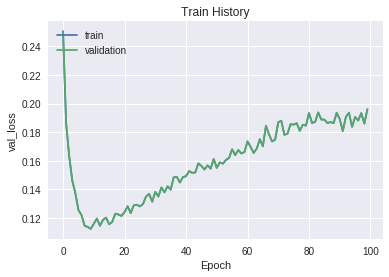

In [0]:
show_train_history(train_history7,"val_loss","val_loss")

## PCA降維預處理搭配MLP
Dropout=0.1

In [0]:
tStart8 = time.time()
model = Sequential()
layers = 1
units = 128
#用2層fully connect全連接層(不含Input和Output層)做NN
model.add(Dense(units, input_dim=NCOMPONENTS, activation='relu'))
#加bias
model.add(GaussianNoise(pca_std))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    #加bias
    model.add(GaussianNoise(pca_std))
    model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
train_history8=model.fit(X_pca_train,mnist.train.labels, epochs=100, batch_size=100, verbose=2,validation_split=0.2)
tEnd8 = time.time()
duration8=tEnd8-tStart8
print("Train Finished takes:",duration8,"sec")

Train on 44000 samples, validate on 11000 samples
Epoch 1/100
 - 3s - loss: 0.9755 - categorical_accuracy: 0.7341 - val_loss: 0.2547 - val_categorical_accuracy: 0.9284
Epoch 2/100
 - 2s - loss: 0.3469 - categorical_accuracy: 0.9001 - val_loss: 0.1852 - val_categorical_accuracy: 0.9466
Epoch 3/100
 - 2s - loss: 0.2442 - categorical_accuracy: 0.9280 - val_loss: 0.1589 - val_categorical_accuracy: 0.9549
Epoch 4/100
 - 2s - loss: 0.1903 - categorical_accuracy: 0.9423 - val_loss: 0.1370 - val_categorical_accuracy: 0.9621
Epoch 5/100
 - 2s - loss: 0.1574 - categorical_accuracy: 0.9524 - val_loss: 0.1253 - val_categorical_accuracy: 0.9636
Epoch 6/100
 - 2s - loss: 0.1319 - categorical_accuracy: 0.9588 - val_loss: 0.1200 - val_categorical_accuracy: 0.9655
Epoch 7/100
 - 2s - loss: 0.1154 - categorical_accuracy: 0.9647 - val_loss: 0.1142 - val_categorical_accuracy: 0.9689
Epoch 8/100
 - 2s - loss: 0.0976 - categorical_accuracy: 0.9689 - val_loss: 0.1165 - val_categorical_accuracy: 0.9685
Epoch 

In [0]:
scores8=model.evaluate(X_pca_test,mnist.test.labels)
print()
print("Accuuracy=",scores8[1])

10000/10000 [==============================] - 0s 27us/step

Accuuracy= 0.9746


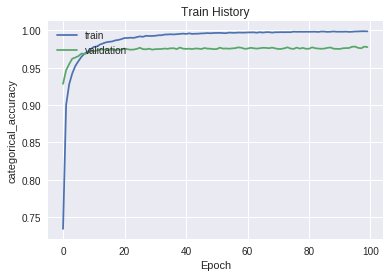

In [0]:
show_train_history(train_history8,"categorical_accuracy","val_categorical_accuracy")

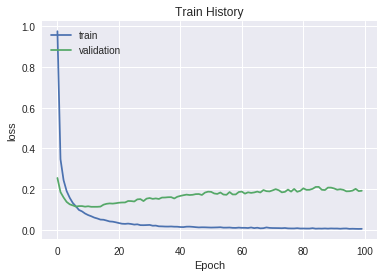

In [0]:
show_train_history(train_history8,"loss","val_loss")

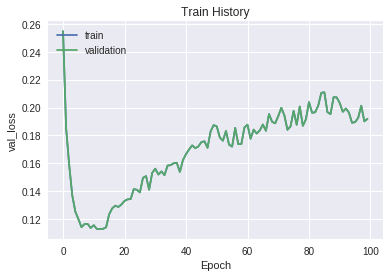

In [0]:
show_train_history(train_history8,"val_loss","val_loss")

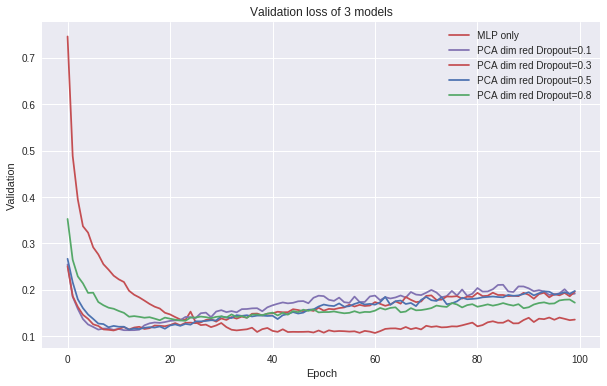

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Validation loss of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Validation")
plt.plot(x,train_history1.history["val_loss"], 'C2', label='MLP only')
plt.plot(x,train_history8.history["val_loss"], 'C9', label='PCA dim red Dropout=0.1')
plt.plot(x,train_history7.history["val_loss"], 'C8', label='PCA dim red Dropout=0.3')
plt.plot(x,train_history6.history["val_loss"], 'C0', label='PCA dim red Dropout=0.5')
plt.plot(x,train_history.history["val_loss"], 'C1', label='PCA dim red Dropout=0.8')
plt.legend()

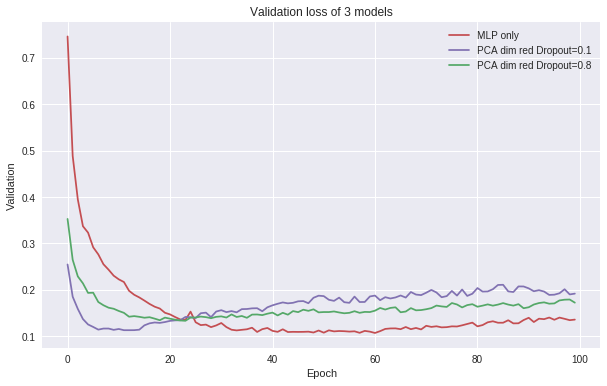

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Validation loss of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Validation")
plt.plot(x,train_history1.history["val_loss"], 'C2', label='MLP only')
plt.plot(x,train_history8.history["val_loss"], 'C9', label='PCA dim red Dropout=0.1')
plt.plot(x,train_history.history["val_loss"], 'C1', label='PCA dim red Dropout=0.8')
plt.legend()

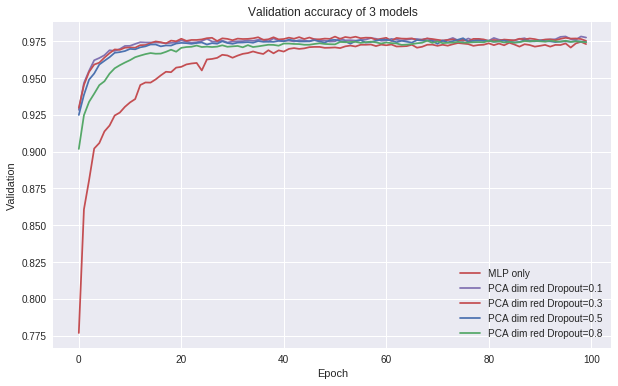

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Validation accuracy of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Validation")
plt.plot(x,train_history1.history["val_categorical_accuracy"], 'C2', label='MLP only')
plt.plot(x,train_history8.history["val_categorical_accuracy"], 'C9', label='PCA dim red Dropout=0.1')
plt.plot(x,train_history7.history["val_categorical_accuracy"], 'C8', label='PCA dim red Dropout=0.3')
plt.plot(x,train_history6.history["val_categorical_accuracy"], 'C0', label='PCA dim red Dropout=0.5')
plt.plot(x,train_history.history["val_categorical_accuracy"], 'C1', label='PCA dim red Dropout=0.8')
plt.legend()

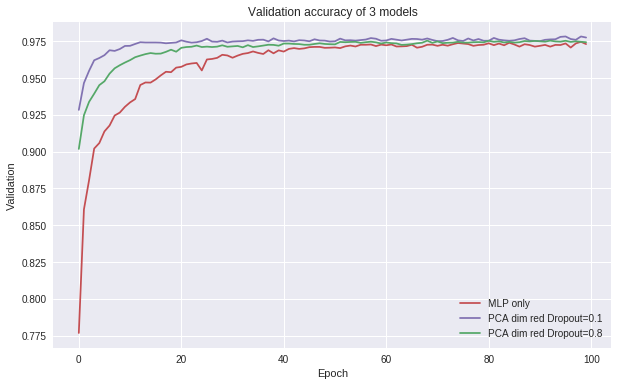

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Validation accuracy of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Validation")
plt.plot(x,train_history1.history["val_categorical_accuracy"], 'C2', label='MLP only')
plt.plot(x,train_history8.history["val_categorical_accuracy"], 'C9', label='PCA dim red Dropout=0.1')
plt.plot(x,train_history.history["val_categorical_accuracy"], 'C1', label='PCA dim red Dropout=0.8')
plt.legend()

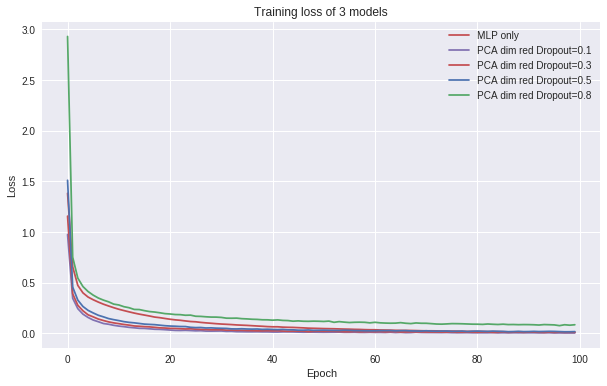

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Training loss of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,train_history1.history["loss"], 'C2', label='MLP only')
plt.plot(x,train_history8.history["loss"], 'C9', label='PCA dim red Dropout=0.1')
plt.plot(x,train_history7.history["loss"], 'C8', label='PCA dim red Dropout=0.3')
plt.plot(x,train_history6.history["loss"], 'C0', label='PCA dim red Dropout=0.5')
plt.plot(x,train_history.history["loss"], 'C1', label='PCA dim red Dropout=0.8')
plt.legend()

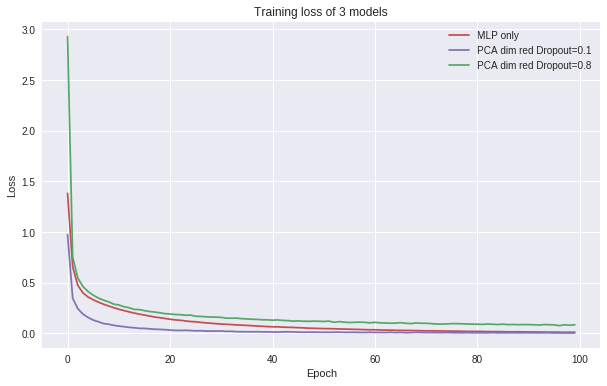

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Training loss of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,train_history1.history["loss"], 'C2', label='MLP only')
plt.plot(x,train_history8.history["loss"], 'C9', label='PCA dim red Dropout=0.1')
plt.plot(x,train_history.history["loss"], 'C1', label='PCA dim red Dropout=0.8')
plt.legend()

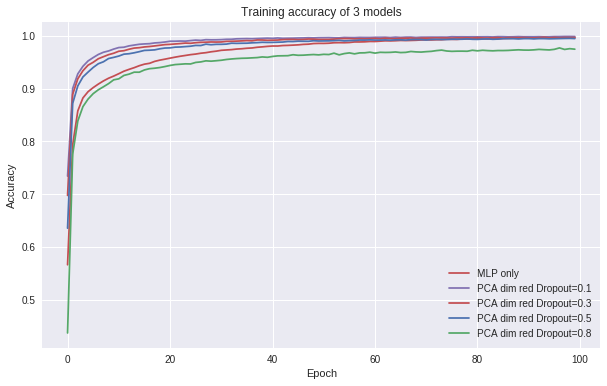

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Training accuracy of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(x,train_history1.history["categorical_accuracy"], 'C2', label='MLP only')
plt.plot(x,train_history8.history["categorical_accuracy"], 'C9', label='PCA dim red Dropout=0.1')
plt.plot(x,train_history7.history["categorical_accuracy"], 'C8', label='PCA dim red Dropout=0.3')
plt.plot(x,train_history6.history["categorical_accuracy"], 'C0', label='PCA dim red Dropout=0.5')
plt.plot(x,train_history.history["categorical_accuracy"], 'C1', label='PCA dim red Dropout=0.8')
plt.legend()

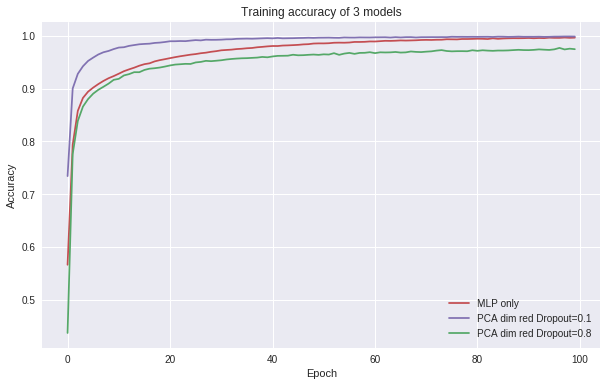

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Training accuracy of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(x,train_history1.history["categorical_accuracy"], 'C2', label='MLP only')
plt.plot(x,train_history8.history["categorical_accuracy"], 'C9', label='PCA dim red Dropout=0.1')
plt.plot(x,train_history.history["categorical_accuracy"], 'C1', label='PCA dim red Dropout=0.8')
plt.legend()

## MLP Only
Dropout=0.1

In [0]:
test1=test.astype("float32")
train1=train.astype("float32")
test_normalize = test1/255
train_normalize = train1/255

In [0]:
std = np.std(train_normalize)

In [0]:
tStart1 = time.time()
model = Sequential()
layers = 1
units = 128
#用2層fully connect全連接層(不含Input和Output層)做NN
model.add(Dense(units, input_dim=28*28, activation='relu'))
#加bias
model.add(GaussianNoise(std))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    #加bias
    model.add(GaussianNoise(std))
    model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
train_history1=model.fit(train_normalize,mnist.train.labels, epochs=100, batch_size=100, verbose=2,validation_split=0.2)
tEnd1 = time.time()
duration1=tEnd1-tStart1
print("Train Finished takes:",duration1,"sec")

Train on 44000 samples, validate on 11000 samples
Epoch 1/100
 - 3s - loss: 1.3826 - categorical_accuracy: 0.5661 - val_loss: 0.7462 - val_categorical_accuracy: 0.7767
Epoch 2/100
 - 3s - loss: 0.6574 - categorical_accuracy: 0.7935 - val_loss: 0.4886 - val_categorical_accuracy: 0.8607
Epoch 3/100
 - 3s - loss: 0.4738 - categorical_accuracy: 0.8578 - val_loss: 0.3949 - val_categorical_accuracy: 0.8805
Epoch 4/100
 - 3s - loss: 0.4002 - categorical_accuracy: 0.8823 - val_loss: 0.3372 - val_categorical_accuracy: 0.9021
Epoch 5/100
 - 3s - loss: 0.3588 - categorical_accuracy: 0.8941 - val_loss: 0.3233 - val_categorical_accuracy: 0.9058
Epoch 6/100
 - 3s - loss: 0.3324 - categorical_accuracy: 0.9019 - val_loss: 0.2917 - val_categorical_accuracy: 0.9137
Epoch 7/100
 - 3s - loss: 0.3092 - categorical_accuracy: 0.9085 - val_loss: 0.2764 - val_categorical_accuracy: 0.9177
Epoch 8/100
 - 3s - loss: 0.2884 - categorical_accuracy: 0.9145 - val_loss: 0.2552 - val_categorical_accuracy: 0.9245
Epoch 

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
None

In [0]:
scores1=model.evaluate(test_normalize,mnist.test.labels)
print()
print("Accuuracy=",scores1[1])

10000/10000 [==============================] - 0s 28us/step

Accuuracy= 0.9762


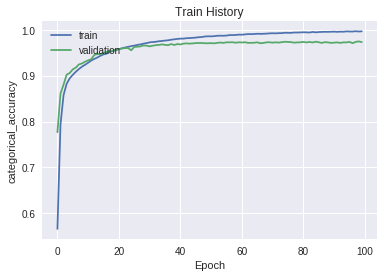

In [0]:
show_train_history(train_history1,"categorical_accuracy","val_categorical_accuracy")

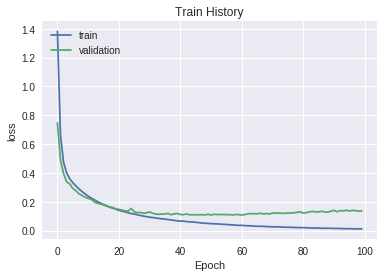

In [0]:
show_train_history(train_history1,"loss","val_loss")

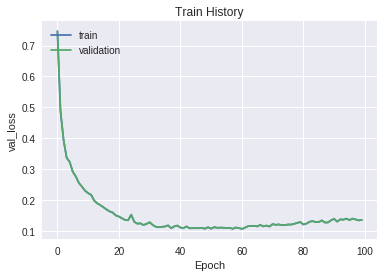

In [0]:
show_train_history(train_history1,"val_loss","val_loss")

## PCA預處理除噪音搭配NN
Dropout=0.1


In [0]:
std_inv_sc = np.std(inv_sc)

In [0]:
tStart2 = time.time()
model = Sequential()
layers = 1
units = 128
#用2層fully connect全連接層(不含Input和Output層)做NN
model.add(Dense(units, input_dim=28*28, activation='relu'))
#加bias
model.add(GaussianNoise(std_inv_sc))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    #加bias
    model.add(GaussianNoise(std_inv_sc))
    model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
train_history2=model.fit(inv_sc,mnist.train.labels, epochs=100, batch_size=100, verbose=2,validation_split=0.2)
tEnd2 = time.time()
duration2=tEnd2-tStart2
print("Train Finished takes:",duration2,"sec")

Train on 44000 samples, validate on 11000 samples
Epoch 1/100
 - 3s - loss: 0.4197 - categorical_accuracy: 0.8718 - val_loss: 0.1945 - val_categorical_accuracy: 0.9418
Epoch 2/100
 - 3s - loss: 0.1993 - categorical_accuracy: 0.9395 - val_loss: 0.1493 - val_categorical_accuracy: 0.9574
Epoch 3/100
 - 3s - loss: 0.1472 - categorical_accuracy: 0.9550 - val_loss: 0.1220 - val_categorical_accuracy: 0.9637
Epoch 4/100
 - 3s - loss: 0.1172 - categorical_accuracy: 0.9636 - val_loss: 0.1026 - val_categorical_accuracy: 0.9676
Epoch 5/100
 - 3s - loss: 0.0970 - categorical_accuracy: 0.9696 - val_loss: 0.0973 - val_categorical_accuracy: 0.9723
Epoch 6/100
 - 3s - loss: 0.0849 - categorical_accuracy: 0.9734 - val_loss: 0.0911 - val_categorical_accuracy: 0.9743
Epoch 7/100
 - 3s - loss: 0.0769 - categorical_accuracy: 0.9764 - val_loss: 0.0900 - val_categorical_accuracy: 0.9741
Epoch 8/100
 - 3s - loss: 0.0680 - categorical_accuracy: 0.9786 - val_loss: 0.0882 - val_categorical_accuracy: 0.9764
Epoch 

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
gaussian_noise_5 (GaussianNo (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
gaussian_noise_6 (GaussianNo (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
None

In [0]:
scores2=model.evaluate(inv_sc_test,mnist.test.labels)
print()
print("Accuuracy=",scores2[1])

10000/10000 [==============================] - 0s 28us/step

Accuuracy= 0.9814


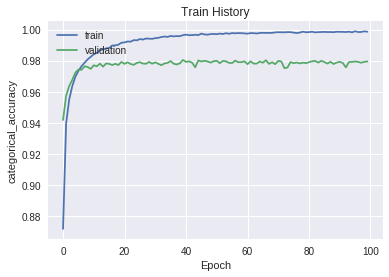

In [0]:
show_train_history(train_history2,"categorical_accuracy","val_categorical_accuracy")

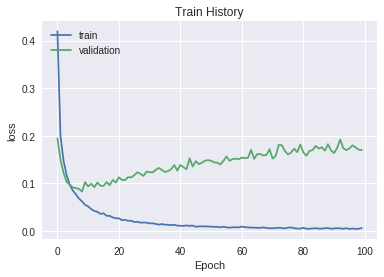

In [0]:
show_train_history(train_history2,"loss","val_loss")

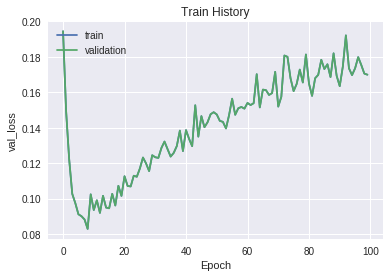

In [0]:
show_train_history(train_history2,"val_loss","val_loss")

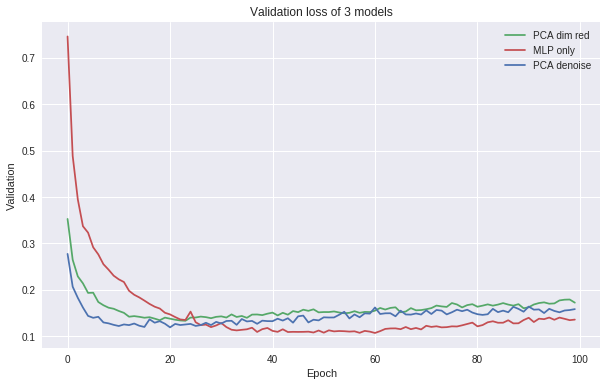

In [102]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Validation loss of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Validation")
plt.plot(x,train_history.history["val_loss"], 'C1', label='PCA dim red')
plt.plot(x,train_history1.history["val_loss"], 'C2', label='MLP only')
plt.plot(x,train_history3.history["val_loss"], 'C6', label='PCA denoise')
plt.legend()

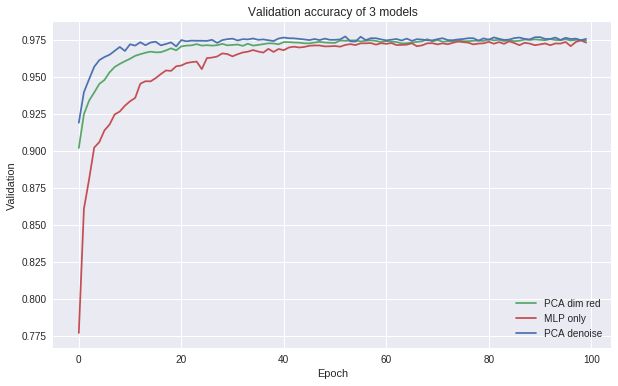

In [103]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Validation accuracy of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Validation")
plt.plot(x,train_history.history["val_categorical_accuracy"], 'C1', label='PCA dim red')
plt.plot(x,train_history1.history["val_categorical_accuracy"], 'C2', label='MLP only')
plt.plot(x,train_history3.history["val_categorical_accuracy"], 'C6', label='PCA denoise')
plt.legend()

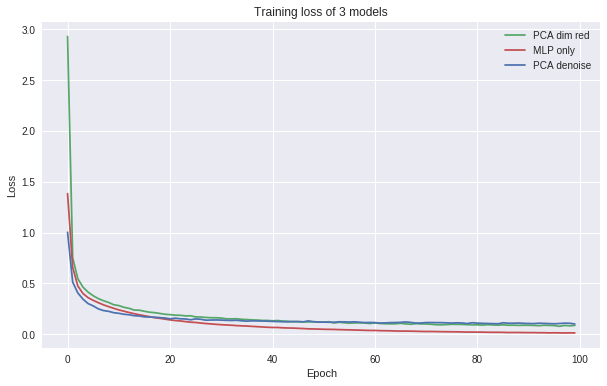

In [104]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Training loss of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,train_history.history["loss"], 'C1', label='PCA dim red')
plt.plot(x,train_history1.history["loss"], 'C2', label='MLP only')
plt.plot(x,train_history3.history["loss"], 'C6', label='PCA denoise')
plt.legend()

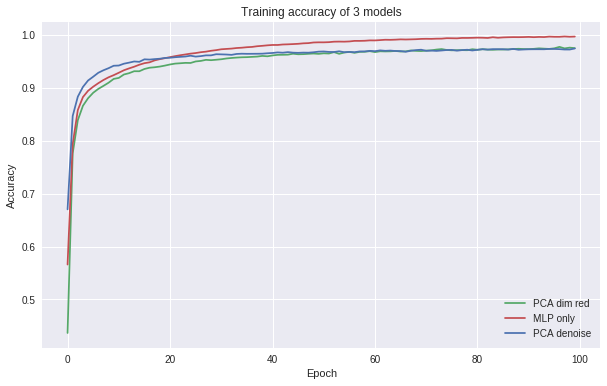

In [105]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Training accuracy of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(x,train_history.history["categorical_accuracy"], 'C1', label='PCA dim red')
plt.plot(x,train_history1.history["categorical_accuracy"], 'C2', label='MLP only')
plt.plot(x,train_history3.history["categorical_accuracy"], 'C6', label='PCA denoise')
plt.legend()

## PCA預處理除噪音搭配NN
Dropout=0.8


In [0]:
tStart3 = time.time()
model = Sequential()
layers = 1
units = 128
#用2層fully connect全連接層(不含Input和Output層)做NN
model.add(Dense(units, input_dim=28*28, activation='relu'))
#加bias
model.add(GaussianNoise(std_inv_sc))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    #加bias
    model.add(GaussianNoise(std_inv_sc))
    model.add(Dropout(0.8))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
train_history3=model.fit(inv_sc,mnist.train.labels, epochs=100, batch_size=100, verbose=2,validation_split=0.2)
tEnd3 = time.time()
duration3=tEnd3-tStart3
print("Train Finished takes:",duration3,"sec")

Train on 44000 samples, validate on 11000 samples
Epoch 1/100
 - 3s - loss: 1.0027 - categorical_accuracy: 0.6702 - val_loss: 0.2775 - val_categorical_accuracy: 0.9189
Epoch 2/100
 - 3s - loss: 0.5115 - categorical_accuracy: 0.8465 - val_loss: 0.2068 - val_categorical_accuracy: 0.9396
Epoch 3/100
 - 3s - loss: 0.4052 - categorical_accuracy: 0.8830 - val_loss: 0.1827 - val_categorical_accuracy: 0.9483
Epoch 4/100
 - 2s - loss: 0.3446 - categorical_accuracy: 0.9014 - val_loss: 0.1619 - val_categorical_accuracy: 0.9567
Epoch 5/100
 - 3s - loss: 0.3006 - categorical_accuracy: 0.9136 - val_loss: 0.1438 - val_categorical_accuracy: 0.9613
Epoch 6/100
 - 3s - loss: 0.2777 - categorical_accuracy: 0.9207 - val_loss: 0.1397 - val_categorical_accuracy: 0.9634
Epoch 7/100
 - 3s - loss: 0.2485 - categorical_accuracy: 0.9282 - val_loss: 0.1418 - val_categorical_accuracy: 0.9649
Epoch 8/100
 - 2s - loss: 0.2318 - categorical_accuracy: 0.9329 - val_loss: 0.1297 - val_categorical_accuracy: 0.9675
Epoch 

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
gaussian_noise_7 (GaussianNo (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
gaussian_noise_8 (GaussianNo (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
None

In [0]:
scores3=model.evaluate(inv_sc_test,mnist.test.labels)
print()
print("Accuuracy=",scores3[1])

10000/10000 [==============================] - 0s 28us/step

Accuuracy= 0.9773


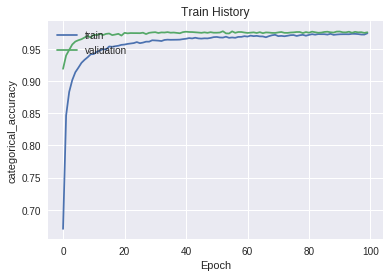

In [0]:
show_train_history(train_history3,"categorical_accuracy","val_categorical_accuracy")

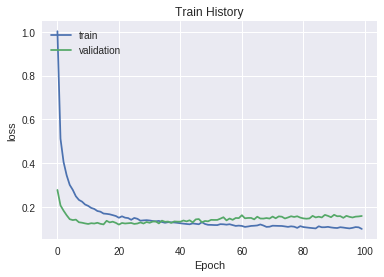

In [0]:
show_train_history(train_history3,"loss","val_loss")

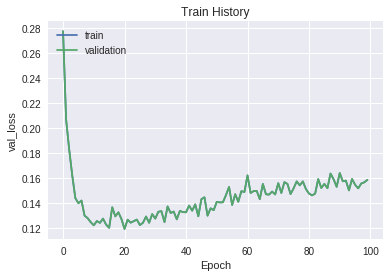

In [0]:
show_train_history(train_history3,"val_loss","val_loss")

## PCA預處理除噪音搭配NN
Dropout=0.5


In [0]:
tStart4 = time.time()
model = Sequential()
layers = 1
units = 128
#用2層fully connect全連接層(不含Input和Output層)做NN
model.add(Dense(units, input_dim=28*28, activation='relu'))
#加bias
model.add(GaussianNoise(std_inv_sc))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    #加bias
    model.add(GaussianNoise(std_inv_sc))
    model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
train_history4=model.fit(inv_sc,mnist.train.labels, epochs=100, batch_size=100, verbose=2,validation_split=0.2)
tEnd4 = time.time()
duration4=tEnd4-tStart4
print("Train Finished takes:",duration4,"sec")

Train on 44000 samples, validate on 11000 samples
Epoch 1/100
 - 3s - loss: 0.5888 - categorical_accuracy: 0.8125 - val_loss: 0.2117 - val_categorical_accuracy: 0.9378
Epoch 2/100
 - 3s - loss: 0.2851 - categorical_accuracy: 0.9164 - val_loss: 0.1565 - val_categorical_accuracy: 0.9534
Epoch 3/100
 - 3s - loss: 0.2245 - categorical_accuracy: 0.9352 - val_loss: 0.1375 - val_categorical_accuracy: 0.9589
Epoch 4/100
 - 3s - loss: 0.1813 - categorical_accuracy: 0.9463 - val_loss: 0.1148 - val_categorical_accuracy: 0.9659
Epoch 5/100
 - 3s - loss: 0.1617 - categorical_accuracy: 0.9519 - val_loss: 0.1172 - val_categorical_accuracy: 0.9667
Epoch 6/100
 - 3s - loss: 0.1433 - categorical_accuracy: 0.9578 - val_loss: 0.1077 - val_categorical_accuracy: 0.9700
Epoch 7/100
 - 3s - loss: 0.1303 - categorical_accuracy: 0.9620 - val_loss: 0.1016 - val_categorical_accuracy: 0.9698
Epoch 8/100
 - 3s - loss: 0.1221 - categorical_accuracy: 0.9647 - val_loss: 0.1053 - val_categorical_accuracy: 0.9706
Epoch 

In [0]:
scores4=model.evaluate(inv_sc_test,mnist.test.labels)
print()
print("Accuuracy=",scores4[1])

10000/10000 [==============================] - 0s 28us/step

Accuuracy= 0.9805


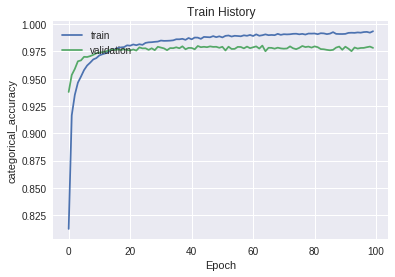

In [0]:
show_train_history(train_history4,"categorical_accuracy","val_categorical_accuracy")

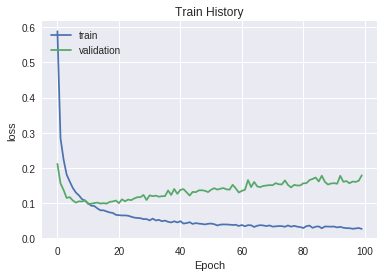

In [0]:
show_train_history(train_history4,"loss","val_loss")

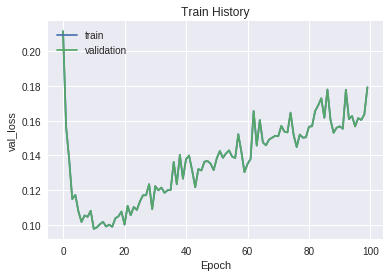

In [0]:
show_train_history(train_history4,"val_loss","val_loss")

## PCA預處理除噪音搭配NN
Dropout=0.3


In [0]:
tStart5 = time.time()
model = Sequential()
layers = 1
units = 128
#用2層fully connect全連接層(不含Input和Output層)做NN
model.add(Dense(units, input_dim=28*28, activation='relu'))
#加bias
model.add(GaussianNoise(std_inv_sc))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    #加bias
    model.add(GaussianNoise(std_inv_sc))
    model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
train_history5=model.fit(inv_sc,mnist.train.labels, epochs=100, batch_size=100, verbose=2,validation_split=0.2)
tEnd5 = time.time()
duration5=tEnd5-tStart5
print("Train Finished takes:",duration5,"sec")

Train on 44000 samples, validate on 11000 samples
Epoch 1/100
 - 4s - loss: 0.4741 - categorical_accuracy: 0.8518 - val_loss: 0.1980 - val_categorical_accuracy: 0.9406
Epoch 2/100
 - 3s - loss: 0.2299 - categorical_accuracy: 0.9300 - val_loss: 0.1435 - val_categorical_accuracy: 0.9583
Epoch 3/100
 - 3s - loss: 0.1723 - categorical_accuracy: 0.9478 - val_loss: 0.1172 - val_categorical_accuracy: 0.9655
Epoch 4/100
 - 3s - loss: 0.1420 - categorical_accuracy: 0.9567 - val_loss: 0.1010 - val_categorical_accuracy: 0.9696
Epoch 5/100
 - 3s - loss: 0.1214 - categorical_accuracy: 0.9637 - val_loss: 0.0947 - val_categorical_accuracy: 0.9721
Epoch 6/100
 - 3s - loss: 0.1100 - categorical_accuracy: 0.9665 - val_loss: 0.0973 - val_categorical_accuracy: 0.9731
Epoch 7/100
 - 3s - loss: 0.0990 - categorical_accuracy: 0.9698 - val_loss: 0.0906 - val_categorical_accuracy: 0.9742
Epoch 8/100
 - 3s - loss: 0.0872 - categorical_accuracy: 0.9732 - val_loss: 0.0944 - val_categorical_accuracy: 0.9732
Epoch 

In [0]:
scores5=model.evaluate(inv_sc_test,mnist.test.labels)
print()
print("Accuuracy=",scores5[1])

10000/10000 [==============================] - 0s 29us/step

Accuuracy= 0.9789


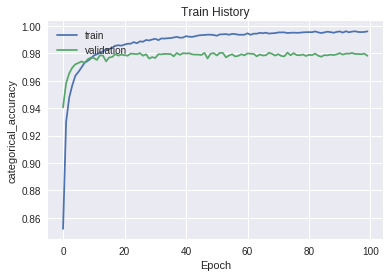

In [0]:
show_train_history(train_history5,"categorical_accuracy","val_categorical_accuracy")

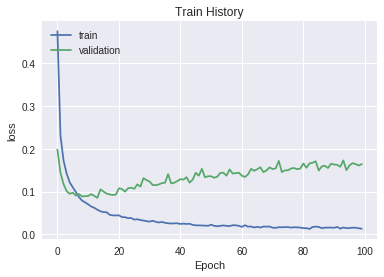

In [0]:
show_train_history(train_history5,"loss","val_loss")

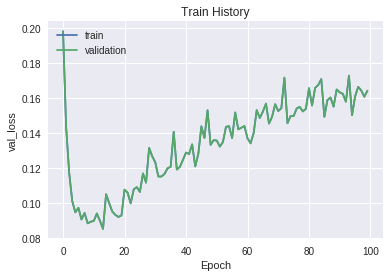

In [0]:
show_train_history(train_history5,"val_loss","val_loss")

## PCA預處理除噪音搭配NN
各個dropout比較  


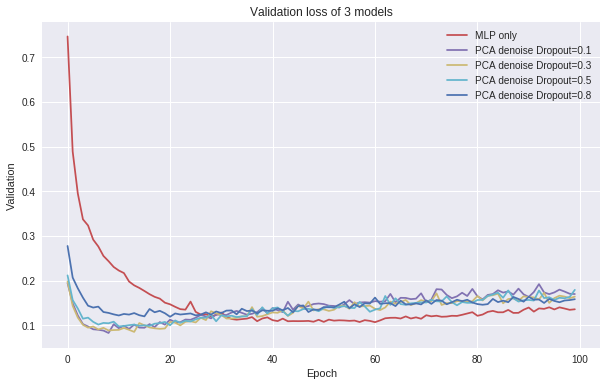

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Validation loss of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Validation")
plt.plot(x,train_history1.history["val_loss"], 'C2', label='MLP only')
plt.plot(x,train_history2.history["val_loss"], 'C3', label='PCA denoise Dropout=0.1')
plt.plot(x,train_history5.history["val_loss"], 'C4', label='PCA denoise Dropout=0.3')
plt.plot(x,train_history4.history["val_loss"], 'C5', label='PCA denoise Dropout=0.5')
plt.plot(x,train_history3.history["val_loss"], 'C6', label='PCA denoise Dropout=0.8')
plt.legend()

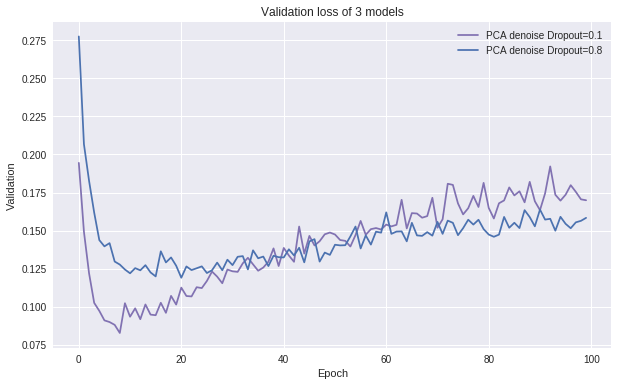

In [0]:
#0.1和0.8有cross
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Validation loss of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Validation")
#plt.plot(x,train_history1.history["val_loss"], 'C2', label='MLP only')
plt.plot(x,train_history2.history["val_loss"], 'C3', label='PCA denoise Dropout=0.1')
plt.plot(x,train_history3.history["val_loss"], 'C6', label='PCA denoise Dropout=0.8')
plt.legend()

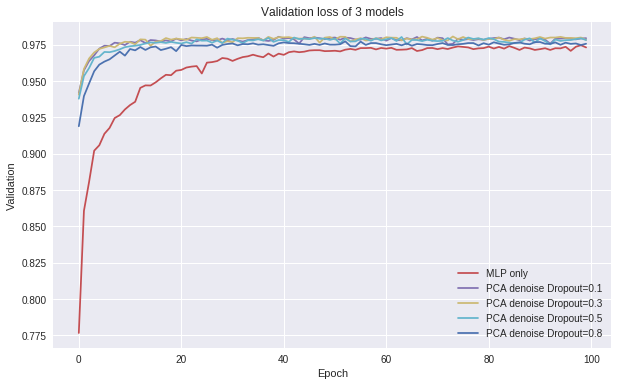

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Validation loss of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Validation")
plt.plot(x,train_history1.history["val_categorical_accuracy"], 'C2', label='MLP only')
plt.plot(x,train_history2.history["val_categorical_accuracy"], 'C3', label='PCA denoise Dropout=0.1')
plt.plot(x,train_history5.history["val_categorical_accuracy"], 'C4', label='PCA denoise Dropout=0.3')
plt.plot(x,train_history4.history["val_categorical_accuracy"], 'C5', label='PCA denoise Dropout=0.5')
plt.plot(x,train_history3.history["val_categorical_accuracy"], 'C6', label='PCA denoise Dropout=0.8')
plt.legend()

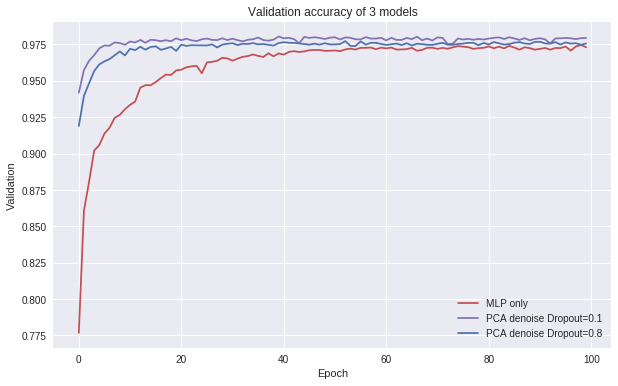

In [0]:
##0.1和0.8的比較
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Validation accuracy of 3 models")
plt.xlabel("Epoch")
plt.ylabel("Validation")
plt.plot(x,train_history1.history["val_categorical_accuracy"], 'C2', label='MLP only')
plt.plot(x,train_history2.history["val_categorical_accuracy"], 'C3', label='PCA denoise Dropout=0.1')
plt.plot(x,train_history3.history["val_categorical_accuracy"], 'C6', label='PCA denoise Dropout=0.8')
plt.legend()

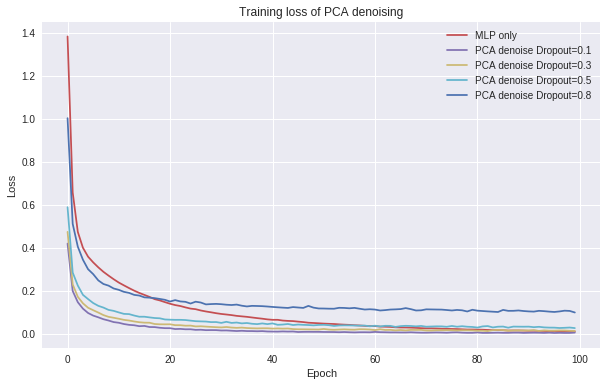

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Training loss of PCA denoising")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,train_history1.history["loss"], 'C2', label='MLP only')
plt.plot(x,train_history2.history["loss"], 'C3', label='PCA denoise Dropout=0.1')
plt.plot(x,train_history5.history["loss"], 'C4', label='PCA denoise Dropout=0.3')
plt.plot(x,train_history4.history["loss"], 'C5', label='PCA denoise Dropout=0.5')
plt.plot(x,train_history3.history["loss"], 'C6', label='PCA denoise Dropout=0.8')
plt.legend()

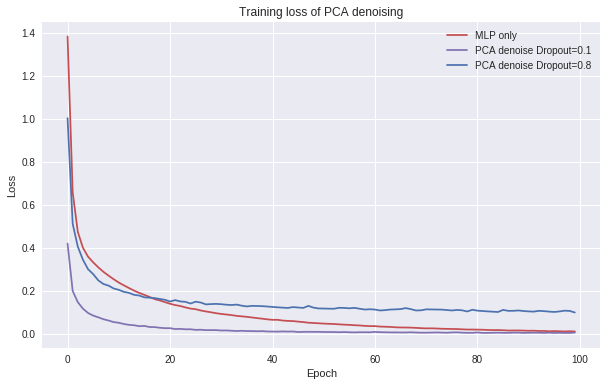

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Training loss of PCA denoising")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,train_history1.history["loss"], 'C2', label='MLP only')
plt.plot(x,train_history2.history["loss"], 'C3', label='PCA denoise Dropout=0.1')
plt.plot(x,train_history3.history["loss"], 'C6', label='PCA denoise Dropout=0.8')
plt.legend()

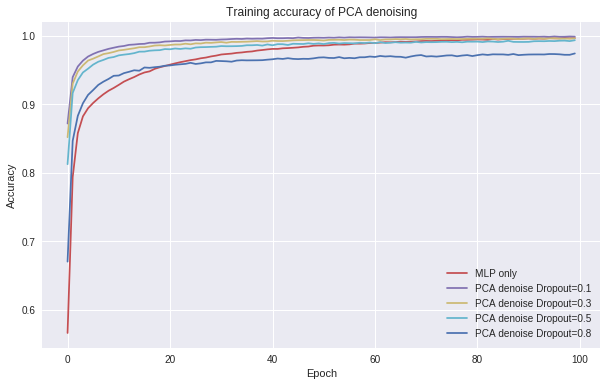

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Training accuracy of PCA denoising")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(x,train_history1.history["categorical_accuracy"], 'C2', label='MLP only')
plt.plot(x,train_history2.history["categorical_accuracy"], 'C3', label='PCA denoise Dropout=0.1')
plt.plot(x,train_history5.history["categorical_accuracy"], 'C4', label='PCA denoise Dropout=0.3')
plt.plot(x,train_history4.history["categorical_accuracy"], 'C5', label='PCA denoise Dropout=0.5')
plt.plot(x,train_history3.history["categorical_accuracy"], 'C6', label='PCA denoise Dropout=0.8')
plt.legend()

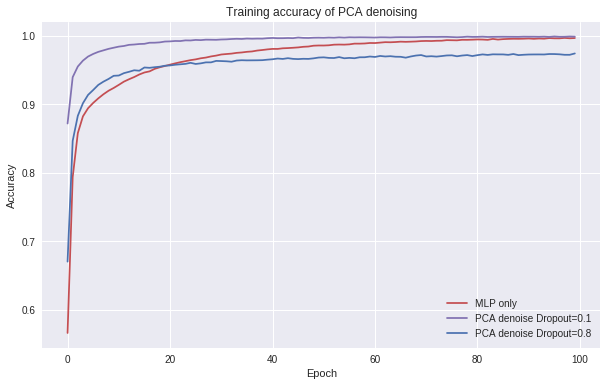

In [0]:
x=list(range(0, 100))
plt.figure(figsize=(10,6))
plt.title("Training accuracy of PCA denoising")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(x,train_history1.history["categorical_accuracy"], 'C2', label='MLP only')
plt.plot(x,train_history2.history["categorical_accuracy"], 'C3', label='PCA denoise Dropout=0.1')
plt.plot(x,train_history3.history["categorical_accuracy"], 'C6', label='PCA denoise Dropout=0.8')
plt.legend()